In [1]:
import shap
from sklearn.datasets import fetch_california_housing
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
import optuna

d:\shap-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
# load the data

data = fetch_california_housing(as_frame=True)

In [3]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [4]:
# make X and y

X, y = data.data, data.target

In [5]:
# columns names

feature_names = data.feature_names

feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [6]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [7]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training data: ", X_train.shape)
print("Shape of Testing data: ", X_test.shape)

Shape of Training data:  (16512, 8)
Shape of Testing data:  (4128, 8)


## Model

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# create a pipeline
scaler = StandardScaler()

# model 
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                         n_jobs=-1, learning_rate=0.2, n_estimators=200,
                         reg_lambda=50, max_depth=7, gamma=0.05)

model_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("reg", xgb_model)    
])

model_pipe

,steps,"[('scaler', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None


In [9]:
# fit the training data
model_pipe.fit(X_train, y_train)

,steps,"[('scaler', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None


In [10]:
# claculate the predictions
y_pred_train = model_pipe.predict(X_train)
y_pred_test = model_pipe.predict(X_test)

# calculate the RMSE and R2 score
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2899, R2: 0.9371
Test RMSE: 0.4474, R2: 0.8472


### HP Tuning

In [11]:
# tune the model

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 2),
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),
        "n_jobs": -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    
    # set the model with the parameters
    model = XGBRegressor()
    
    model.set_params(**params)
    
    # create a pipeline
    model_pipe = Pipeline(steps=[
        ("scaler", scaler),
        ("reg", model)    
    ])
    
    # fit the model
    model_pipe.fit(X_train, y_train)
    
    # predict the test data
    y_pred = model_pipe.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    return rmse

In [12]:
# create a study
study = optuna.create_study(direction='minimize')

study.optimize(func=objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

[I 2025-08-22 12:01:11,322] A new study created in memory with name: no-name-8966ef86-cf42-4058-9fae-a1c51321b224
Best trial: 3. Best value: 0.486706:   2%|▏         | 1/50 [00:03<02:46,  3.40s/it]

[I 2025-08-22 12:01:14,711] Trial 3 finished with value: 0.4867060279505047 and parameters: {'learning_rate': 0.23820697193806578, 'n_estimators': 483, 'max_depth': 4, 'reg_lambda': 30.167990143673222, 'gamma': 1.519296208287503, 'subsample': 0.775381806533908}. Best is trial 3 with value: 0.4867060279505047.


Best trial: 2. Best value: 0.484865:   4%|▍         | 2/50 [00:03<01:17,  1.62s/it]

[I 2025-08-22 12:01:15,085] Trial 2 finished with value: 0.48486547477694086 and parameters: {'learning_rate': 0.10678766698265435, 'n_estimators': 412, 'max_depth': 6, 'reg_lambda': 22.249506639584734, 'gamma': 1.8384085569570274, 'subsample': 0.7197946747435344}. Best is trial 2 with value: 0.48486547477694086.


Best trial: 2. Best value: 0.484865:   6%|▌         | 3/50 [00:04<00:46,  1.00it/s]

[I 2025-08-22 12:01:15,344] Trial 1 finished with value: 0.5014201245424992 and parameters: {'learning_rate': 0.08648144433211584, 'n_estimators': 449, 'max_depth': 3, 'reg_lambda': 7.728837463143432, 'gamma': 1.505940436618974, 'subsample': 0.9114560283825348}. Best is trial 2 with value: 0.48486547477694086.


Best trial: 0. Best value: 0.479498:   8%|▊         | 4/50 [00:04<00:38,  1.20it/s]

[I 2025-08-22 12:01:15,929] Trial 0 finished with value: 0.47949778728230713 and parameters: {'learning_rate': 0.07074451141120822, 'n_estimators': 477, 'max_depth': 10, 'reg_lambda': 8.773028856537778, 'gamma': 1.9769200248114027, 'subsample': 0.8696735704317484}. Best is trial 0 with value: 0.47949778728230713.


Best trial: 4. Best value: 0.447439:  10%|█         | 5/50 [00:06<00:53,  1.19s/it]

[I 2025-08-22 12:01:17,746] Trial 4 finished with value: 0.4474388210894201 and parameters: {'learning_rate': 0.262846388386275, 'n_estimators': 271, 'max_depth': 5, 'reg_lambda': 45.672524159210155, 'gamma': 0.3974871558994093, 'subsample': 0.8559278725277758}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  12%|█▏        | 6/50 [00:07<00:55,  1.25s/it]

[I 2025-08-22 12:01:19,119] Trial 7 finished with value: 0.4704937239414039 and parameters: {'learning_rate': 0.21804195601285986, 'n_estimators': 375, 'max_depth': 9, 'reg_lambda': 7.274920023532261, 'gamma': 0.5056156217893004, 'subsample': 0.9191809754408549}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  14%|█▍        | 7/50 [00:08<00:45,  1.06s/it]

[I 2025-08-22 12:01:19,791] Trial 6 finished with value: 0.47375269668600456 and parameters: {'learning_rate': 0.05973016545052073, 'n_estimators': 262, 'max_depth': 8, 'reg_lambda': 23.09791719522443, 'gamma': 0.8886886644215379, 'subsample': 0.9184611233041795}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  16%|█▌        | 8/50 [00:08<00:35,  1.20it/s]

[I 2025-08-22 12:01:20,138] Trial 5 finished with value: 0.45182323678661446 and parameters: {'learning_rate': 0.253767257803272, 'n_estimators': 198, 'max_depth': 7, 'reg_lambda': 51.20993689890226, 'gamma': 0.024786118412293057, 'subsample': 0.7042870356395897}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  18%|█▊        | 9/50 [00:10<00:49,  1.22s/it]

[I 2025-08-22 12:01:22,189] Trial 8 finished with value: 0.47265093515808493 and parameters: {'learning_rate': 0.05979707287499873, 'n_estimators': 112, 'max_depth': 10, 'reg_lambda': 59.812893796695896, 'gamma': 0.6831485774022827, 'subsample': 0.9699557969678493}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  20%|██        | 10/50 [00:11<00:36,  1.08it/s]

[I 2025-08-22 12:01:22,454] Trial 10 finished with value: 0.4927922147583229 and parameters: {'learning_rate': 0.20700925266043305, 'n_estimators': 370, 'max_depth': 6, 'reg_lambda': 73.17615840301323, 'gamma': 1.9426509947076422, 'subsample': 0.8278037317599332}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  22%|██▏       | 11/50 [00:13<00:48,  1.24s/it]

[I 2025-08-22 12:01:24,416] Trial 13 finished with value: 0.46278089766042324 and parameters: {'learning_rate': 0.293700360125697, 'n_estimators': 103, 'max_depth': 5, 'reg_lambda': 91.76912911004584, 'gamma': 0.12601712350690158, 'subsample': 0.809175124263605}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  24%|██▍       | 12/50 [00:14<00:43,  1.15s/it]

[I 2025-08-22 12:01:25,357] Trial 12 finished with value: 0.4785003083133309 and parameters: {'learning_rate': 0.22915478182418264, 'n_estimators': 426, 'max_depth': 7, 'reg_lambda': 82.5629159486541, 'gamma': 1.0508685701939815, 'subsample': 0.9552113090594515}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  26%|██▌       | 13/50 [00:14<00:33,  1.12it/s]

[I 2025-08-22 12:01:25,671] Trial 11 finished with value: 0.4615048357135344 and parameters: {'learning_rate': 0.09081249293378735, 'n_estimators': 386, 'max_depth': 9, 'reg_lambda': 93.01218216779752, 'gamma': 0.6151501407913595, 'subsample': 0.9349163333595297}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  28%|██▊       | 14/50 [00:17<00:51,  1.43s/it]

[I 2025-08-22 12:01:28,325] Trial 16 finished with value: 0.45339553925916376 and parameters: {'learning_rate': 0.28578713438181247, 'n_estimators': 202, 'max_depth': 5, 'reg_lambda': 45.28440174908179, 'gamma': 0.0702565513347313, 'subsample': 0.7169024863910007}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  30%|███       | 15/50 [00:18<00:48,  1.39s/it]

[I 2025-08-22 12:01:29,634] Trial 14 finished with value: 0.4548945253707797 and parameters: {'learning_rate': 0.29257464974306685, 'n_estimators': 226, 'max_depth': 7, 'reg_lambda': 43.7214367342536, 'gamma': 0.0379582808827823, 'subsample': 0.7007813690585614}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  32%|███▏      | 16/50 [00:18<00:38,  1.15s/it]

[I 2025-08-22 12:01:30,206] Trial 15 finished with value: 0.4517410146250746 and parameters: {'learning_rate': 0.29019373039394103, 'n_estimators': 217, 'max_depth': 7, 'reg_lambda': 48.61076844355788, 'gamma': 0.05776189289966638, 'subsample': 0.7089373208230046}. Best is trial 4 with value: 0.4474388210894201.
[I 2025-08-22 12:01:30,291] Trial 9 finished with value: 0.450289931677888 and parameters: {'learning_rate': 0.04056666114979642, 'n_estimators': 407, 'max_depth': 9, 'reg_lambda': 66.33391969568177, 'gamma': 0.3586518706700019, 'subsample': 0.8259461318141783}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  36%|███▌      | 18/50 [00:20<00:32,  1.02s/it]

[I 2025-08-22 12:01:31,969] Trial 18 finished with value: 0.4633804722189512 and parameters: {'learning_rate': 0.1694519179926372, 'n_estimators': 169, 'max_depth': 5, 'reg_lambda': 63.51011113552288, 'gamma': 0.3490129747255278, 'subsample': 0.7737093111171608}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  38%|███▊      | 19/50 [00:20<00:26,  1.19it/s]

[I 2025-08-22 12:01:32,256] Trial 17 finished with value: 0.4496397718503041 and parameters: {'learning_rate': 0.16430908488824308, 'n_estimators': 194, 'max_depth': 7, 'reg_lambda': 50.22737729627011, 'gamma': 0.29794148803165177, 'subsample': 0.7717013638979017}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 4. Best value: 0.447439:  40%|████      | 20/50 [00:21<00:25,  1.17it/s]

[I 2025-08-22 12:01:33,153] Trial 20 finished with value: 0.6230734911367498 and parameters: {'learning_rate': 0.011032196572388697, 'n_estimators': 328, 'max_depth': 3, 'reg_lambda': 69.86639619934937, 'gamma': 0.3523911471156433, 'subsample': 0.8654113497605157}. Best is trial 4 with value: 0.4474388210894201.


Best trial: 19. Best value: 0.447314:  42%|████▏     | 21/50 [00:23<00:31,  1.10s/it]

[I 2025-08-22 12:01:34,919] Trial 19 finished with value: 0.44731376591401434 and parameters: {'learning_rate': 0.16072531320180883, 'n_estimators': 330, 'max_depth': 5, 'reg_lambda': 64.23009900572691, 'gamma': 0.3094919217152047, 'subsample': 0.7683801259503318}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  44%|████▍     | 22/50 [00:23<00:24,  1.13it/s]

[I 2025-08-22 12:01:35,230] Trial 22 finished with value: 0.49564341994363925 and parameters: {'learning_rate': 0.12687809828729474, 'n_estimators': 312, 'max_depth': 3, 'reg_lambda': 33.054818532987866, 'gamma': 0.952476024081119, 'subsample': 0.8812451701947475}. Best is trial 19 with value: 0.44731376591401434.
[I 2025-08-22 12:01:35,276] Trial 21 finished with value: 0.5757724443879061 and parameters: {'learning_rate': 0.018604954472398294, 'n_estimators': 314, 'max_depth': 3, 'reg_lambda': 71.71874724151816, 'gamma': 1.0254253739868753, 'subsample': 0.8729203251208737}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  48%|████▊     | 24/50 [00:25<00:19,  1.35it/s]

[I 2025-08-22 12:01:36,364] Trial 23 finished with value: 0.4733723963873892 and parameters: {'learning_rate': 0.1359293300237231, 'n_estimators': 294, 'max_depth': 4, 'reg_lambda': 32.81486235359292, 'gamma': 0.9146767342111632, 'subsample': 0.7821809006264063}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  50%|█████     | 25/50 [00:25<00:19,  1.31it/s]

[I 2025-08-22 12:01:37,201] Trial 27 finished with value: 0.48507642599516415 and parameters: {'learning_rate': 0.18096089244191296, 'n_estimators': 57, 'max_depth': 6, 'reg_lambda': 56.60718512708664, 'gamma': 0.2584681978610399, 'subsample': 0.748824440789916}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  52%|█████▏    | 26/50 [00:26<00:16,  1.48it/s]

[I 2025-08-22 12:01:37,613] Trial 25 finished with value: 0.47272446707087445 and parameters: {'learning_rate': 0.17968229842972205, 'n_estimators': 265, 'max_depth': 4, 'reg_lambda': 58.10878566769699, 'gamma': 0.8004884149379478, 'subsample': 0.769566866242284}. Best is trial 19 with value: 0.44731376591401434.
[I 2025-08-22 12:01:37,711] Trial 24 finished with value: 0.4733144407356295 and parameters: {'learning_rate': 0.13975352049090212, 'n_estimators': 310, 'max_depth': 4, 'reg_lambda': 36.3237102227807, 'gamma': 0.8955150017786061, 'subsample': 0.7601368606091723}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  56%|█████▌    | 28/50 [00:26<00:11,  1.99it/s]

[I 2025-08-22 12:01:38,147] Trial 26 finished with value: 0.4613030936833688 and parameters: {'learning_rate': 0.17642026228250227, 'n_estimators': 270, 'max_depth': 4, 'reg_lambda': 55.54099851645827, 'gamma': 0.26578731387503907, 'subsample': 0.7856206958792105}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  60%|██████    | 30/50 [00:28<00:10,  1.91it/s]

[I 2025-08-22 12:01:39,306] Trial 29 finished with value: 0.47404576627830236 and parameters: {'learning_rate': 0.14185991645988982, 'n_estimators': 134, 'max_depth': 5, 'reg_lambda': 40.41789609794333, 'gamma': 0.5002108017281266, 'subsample': 0.743221841953209}. Best is trial 19 with value: 0.44731376591401434.
[I 2025-08-22 12:01:39,431] Trial 30 finished with value: 0.46263440121158317 and parameters: {'learning_rate': 0.19936117713750848, 'n_estimators': 151, 'max_depth': 5, 'reg_lambda': 41.99128614304682, 'gamma': 0.5814078652270787, 'subsample': 0.7994345502558426}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  62%|██████▏   | 31/50 [00:28<00:08,  2.36it/s]

[I 2025-08-22 12:01:39,575] Trial 28 finished with value: 0.47175563080108074 and parameters: {'learning_rate': 0.1875044429491496, 'n_estimators': 272, 'max_depth': 4, 'reg_lambda': 81.93032726375537, 'gamma': 0.7138248373751672, 'subsample': 0.7993892730077663}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  64%|██████▍   | 32/50 [00:28<00:07,  2.27it/s]

[I 2025-08-22 12:01:40,063] Trial 31 finished with value: 0.4630522942839363 and parameters: {'learning_rate': 0.2012175069928363, 'n_estimators': 152, 'max_depth': 5, 'reg_lambda': 84.08585045207437, 'gamma': 0.5155209141451875, 'subsample': 0.7375640827245334}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  66%|██████▌   | 33/50 [00:30<00:13,  1.22it/s]

[I 2025-08-22 12:01:41,849] Trial 32 finished with value: 0.4734501219784257 and parameters: {'learning_rate': 0.20275250393399805, 'n_estimators': 353, 'max_depth': 8, 'reg_lambda': 77.288477985561, 'gamma': 1.19614085788524, 'subsample': 0.8034752979035196}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  68%|██████▊   | 34/50 [00:31<00:16,  1.00s/it]

[I 2025-08-22 12:01:43,307] Trial 34 finished with value: 0.45316711712536967 and parameters: {'learning_rate': 0.2644366444064391, 'n_estimators': 350, 'max_depth': 8, 'reg_lambda': 64.71741650289181, 'gamma': 0.4353082492144771, 'subsample': 0.8328222640680584}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 19. Best value: 0.447314:  70%|███████   | 35/50 [00:32<00:12,  1.19it/s]

[I 2025-08-22 12:01:43,749] Trial 35 finished with value: 0.4515080093547929 and parameters: {'learning_rate': 0.26209217654512407, 'n_estimators': 361, 'max_depth': 8, 'reg_lambda': 63.99451704439399, 'gamma': 0.376331231119614, 'subsample': 0.8930141164151797}. Best is trial 19 with value: 0.44731376591401434.


Best trial: 33. Best value: 0.445905:  72%|███████▏  | 36/50 [00:33<00:13,  1.01it/s]

[I 2025-08-22 12:01:45,116] Trial 33 finished with value: 0.4459046786014738 and parameters: {'learning_rate': 0.2556428445190166, 'n_estimators': 350, 'max_depth': 8, 'reg_lambda': 80.4594866502297, 'gamma': 0.18646451648600504, 'subsample': 0.8410990373641599}. Best is trial 33 with value: 0.4459046786014738.


Best trial: 33. Best value: 0.445905:  74%|███████▍  | 37/50 [00:36<00:18,  1.40s/it]

[I 2025-08-22 12:01:47,475] Trial 36 finished with value: 0.44877334430471916 and parameters: {'learning_rate': 0.15727267034023135, 'n_estimators': 241, 'max_depth': 8, 'reg_lambda': 66.73924457362908, 'gamma': 0.2305881637075448, 'subsample': 0.8383195098992862}. Best is trial 33 with value: 0.4459046786014738.


Best trial: 33. Best value: 0.445905:  76%|███████▌  | 38/50 [00:37<00:17,  1.46s/it]

[I 2025-08-22 12:01:49,094] Trial 39 finished with value: 0.4508856521989289 and parameters: {'learning_rate': 0.24430407038338772, 'n_estimators': 238, 'max_depth': 6, 'reg_lambda': 26.197016712806516, 'gamma': 0.2031794703351325, 'subsample': 0.8491173507474549}. Best is trial 33 with value: 0.4459046786014738.


Best trial: 37. Best value: 0.445673:  78%|███████▊  | 39/50 [00:40<00:18,  1.71s/it]

[I 2025-08-22 12:01:51,392] Trial 37 finished with value: 0.44567252525423257 and parameters: {'learning_rate': 0.11529297039334477, 'n_estimators': 453, 'max_depth': 10, 'reg_lambda': 51.141070014259576, 'gamma': 0.23499757659995069, 'subsample': 0.8432472765581693}. Best is trial 37 with value: 0.44567252525423257.


Best trial: 37. Best value: 0.445673:  80%|████████  | 40/50 [00:41<00:15,  1.52s/it]

[I 2025-08-22 12:01:52,456] Trial 40 finished with value: 0.451620128796088 and parameters: {'learning_rate': 0.1135752447979195, 'n_estimators': 226, 'max_depth': 6, 'reg_lambda': 78.13059482036715, 'gamma': 0.17406657827079022, 'subsample': 0.8535650329642778}. Best is trial 37 with value: 0.44567252525423257.


Best trial: 38. Best value: 0.443521:  82%|████████▏ | 41/50 [00:42<00:12,  1.34s/it]

[I 2025-08-22 12:01:53,374] Trial 38 finished with value: 0.44352080540424266 and parameters: {'learning_rate': 0.1106457306486107, 'n_estimators': 448, 'max_depth': 10, 'reg_lambda': 50.86857461200422, 'gamma': 0.1619875537944948, 'subsample': 0.8448145942852493}. Best is trial 38 with value: 0.44352080540424266.


Best trial: 38. Best value: 0.443521:  84%|████████▍ | 42/50 [00:44<00:13,  1.74s/it]

[I 2025-08-22 12:01:56,035] Trial 42 finished with value: 0.4783306208739843 and parameters: {'learning_rate': 0.09855686950584946, 'n_estimators': 460, 'max_depth': 10, 'reg_lambda': 98.7453597736462, 'gamma': 1.6082866083880347, 'subsample': 0.8568678792436958}. Best is trial 38 with value: 0.44352080540424266.


Best trial: 38. Best value: 0.443521:  86%|████████▌ | 43/50 [00:46<00:12,  1.77s/it]

[I 2025-08-22 12:01:57,876] Trial 43 finished with value: 0.47218168593230486 and parameters: {'learning_rate': 0.07950609748868091, 'n_estimators': 464, 'max_depth': 10, 'reg_lambda': 12.010305349217383, 'gamma': 1.4519926899975948, 'subsample': 0.8135913844397404}. Best is trial 38 with value: 0.44352080540424266.


Best trial: 41. Best value: 0.443297:  88%|████████▊ | 44/50 [00:47<00:08,  1.40s/it]

[I 2025-08-22 12:01:58,428] Trial 41 finished with value: 0.443296738369083 and parameters: {'learning_rate': 0.111495535984856, 'n_estimators': 291, 'max_depth': 10, 'reg_lambda': 99.92092421036479, 'gamma': 0.16097908622677576, 'subsample': 0.9029729434413201}. Best is trial 41 with value: 0.443296738369083.


Best trial: 41. Best value: 0.443297:  90%|█████████ | 45/50 [00:54<00:15,  3.12s/it]

[I 2025-08-22 12:02:05,547] Trial 44 finished with value: 0.45002461227494556 and parameters: {'learning_rate': 0.08835595500930096, 'n_estimators': 459, 'max_depth': 10, 'reg_lambda': 14.088259385753211, 'gamma': 0.1604294404648271, 'subsample': 0.8943169909483595}. Best is trial 41 with value: 0.443296738369083.


Best trial: 41. Best value: 0.443297:  92%|█████████▏| 46/50 [00:56<00:11,  2.77s/it]

[I 2025-08-22 12:02:07,498] Trial 46 finished with value: 0.45019992772094586 and parameters: {'learning_rate': 0.11565757938680858, 'n_estimators': 495, 'max_depth': 9, 'reg_lambda': 52.49883184739178, 'gamma': 0.16183485589667534, 'subsample': 0.9998752862032515}. Best is trial 41 with value: 0.443296738369083.


Best trial: 41. Best value: 0.443297:  94%|█████████▍| 47/50 [01:00<00:09,  3.08s/it]

[I 2025-08-22 12:02:11,323] Trial 45 finished with value: 0.4519328589874856 and parameters: {'learning_rate': 0.07378384634531912, 'n_estimators': 480, 'max_depth': 10, 'reg_lambda': 12.550587655338, 'gamma': 0.17546643164302794, 'subsample': 0.890900227650546}. Best is trial 41 with value: 0.443296738369083.


Best trial: 47. Best value: 0.442984:  96%|█████████▌| 48/50 [01:02<00:06,  3.03s/it]

[I 2025-08-22 12:02:14,212] Trial 47 finished with value: 0.44298376766172726 and parameters: {'learning_rate': 0.11488841064487942, 'n_estimators': 488, 'max_depth': 9, 'reg_lambda': 89.47413403366136, 'gamma': 0.1362004385469151, 'subsample': 0.8983912920161105}. Best is trial 47 with value: 0.44298376766172726.


Best trial: 48. Best value: 0.440236:  98%|█████████▊| 49/50 [01:04<00:02,  2.71s/it]

[I 2025-08-22 12:02:16,190] Trial 48 finished with value: 0.44023560003459744 and parameters: {'learning_rate': 0.11091041900579468, 'n_estimators': 427, 'max_depth': 9, 'reg_lambda': 88.65735322747062, 'gamma': 0.13526930645280494, 'subsample': 0.9046517337600483}. Best is trial 48 with value: 0.44023560003459744.


Best trial: 49. Best value: 0.438155: 100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

[I 2025-08-22 12:02:19,824] Trial 49 finished with value: 0.4381550005457884 and parameters: {'learning_rate': 0.10154042878659061, 'n_estimators': 433, 'max_depth': 9, 'reg_lambda': 89.14072572955152, 'gamma': 0.009335816838667133, 'subsample': 0.88336314348086}. Best is trial 49 with value: 0.4381550005457884.


In [13]:
# get the best parameters
study.best_params

{'learning_rate': 0.10154042878659061,
 'n_estimators': 433,
 'max_depth': 9,
 'reg_lambda': 89.14072572955152,
 'gamma': 0.009335816838667133,
 'subsample': 0.88336314348086}

In [14]:
# get the best value
study.best_value

0.4381550005457884

In [15]:
# get the best estimator
best_model = XGBRegressor(**study.best_params)
best_model_pipe = Pipeline(steps=[
    ("scaler", scaler),
    ("reg", best_model)    
])

best_model_pipe.fit(X_train, y_train)

,steps,"[('scaler', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None


In [16]:
# print the metrics
y_pred_train = best_model_pipe.predict(X_train)
y_pred_test = best_model_pipe.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

print(f"Train R2: {r2_train:.4f}")
print(f"Test R2: {r2_test:.4f}")

Train RMSE: 0.2080, R2: 0.9676
Test RMSE: 0.4383, R2: 0.8534
Train R2: 0.9676
Test R2: 0.8534


## SHAP

In [18]:
# scale the data

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,
                               data=X_train,
                               feature_names=feature_names)

In [23]:
# expected value
explainer.expected_value

np.float64(2.5105219540582877)

In [24]:
# calculate the shap values for all test data

shap_values = explainer(X_test_scaled)

100%|===================| 4127/4128 [10:17<00:00]        

In [25]:
shap_values.shape

(4128, 8)

In [29]:
len(feature_names)

8

In [30]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [28]:
shap_values[0:5]

.values =
array([[-1.39367229,  0.02394062, -0.54428921, -0.06004751, -0.15220224,
        -0.07681457,  0.78771271, -0.57443986],
       [-1.64741692, -0.06643862, -0.34098618, -0.01055064, -0.03376176,
        -0.10250734,  1.11154319, -0.52533383],
       [-0.21452441,  0.        , -0.14749793,  0.07770914,  0.26633317,
         0.38999603,  2.01973617,  0.15775917],
       [-1.01326006,  0.04975015, -0.24017981, -0.05508119,  0.0828168 ,
         0.06145289,  1.47728767, -0.27298512],
       [-1.26786277, -0.00881167, -0.28783524,  0.1204313 , -0.03090603,
         0.13066575,  1.56700448, -0.17430644]])

.base_values =
array([2.51052195, 2.51052195, 2.51052195, 2.51052195, 2.51052195])

.data =
array([[-1.15508475, -0.28632369, -0.52068576, -0.17174603, -0.03030109,
         0.06740798,  0.1951    ,  0.28534728],
       [-0.70865905,  0.11043502, -0.16581537,  0.22347203,  0.12185077,
        -0.03602975, -0.23549054,  0.06097472],
       [-0.21040155,  1.85617335, -0.61076476,  0

### GLOBAL PLOTS

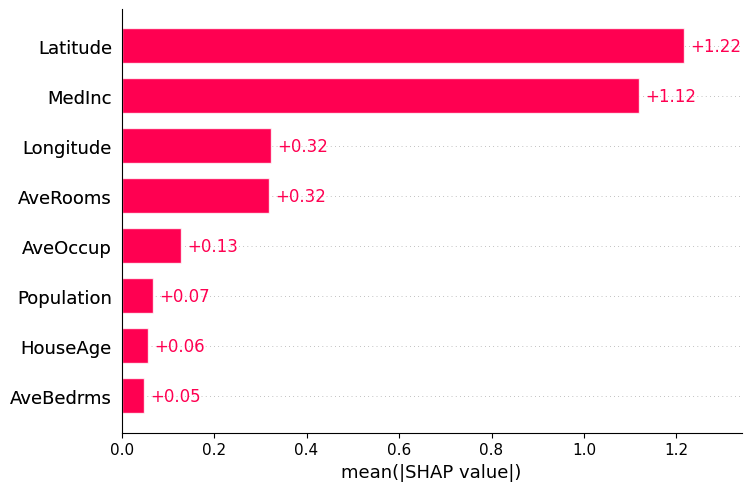

In [32]:
# bar plot to plot feature importance

shap.plots.bar(shap_values)

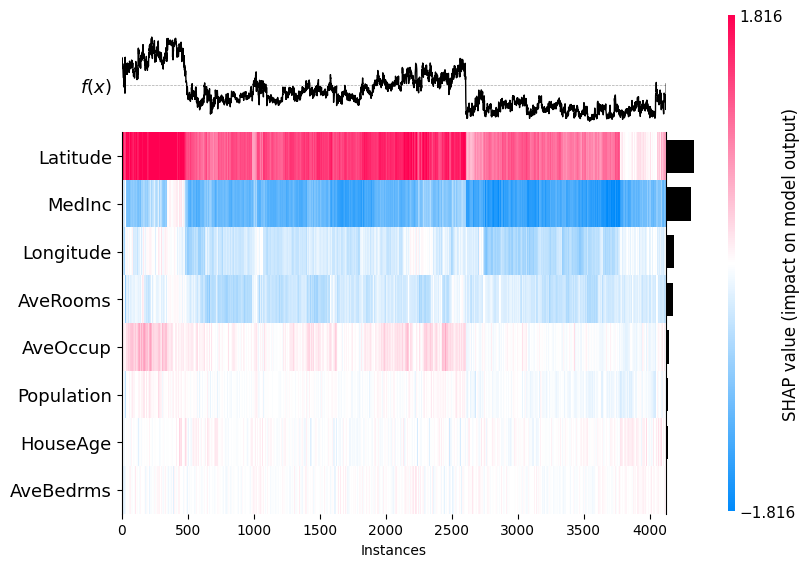

<Axes: xlabel='Instances'>

In [34]:
# heatmap plot

shap.plots.heatmap(shap_values)